In [9]:
import numpy as np

import keras
from keras.datasets import boston_housing

### Using built-in dataset

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 1us/step


In [15]:
col_means = np.mean(train_data, axis=0)
# axis=0 because i want to "run" over the rows, even though the answer is over the columns
col_stds = np.std(train_data, axis=0)
train_data -= col_means
train_data /= col_stds

# also do the same for test data (based on train data though -- those are the \mu and \sigma we've learnt)
test_data -= col_means
test_data /= col_stds

In [16]:
def build_model(l1=64, l2=64):
    model = keras.models.Sequential([
        keras.layers.Dense(l1, activation='relu'),
        keras.layers.Dense(l2, activation='relu'),
        keras.layers.Dense(1)  # no activation, need linear output
    ])
    model.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])
    return model

In [39]:
# cross validation loop
K = 4
num_val_samples = train_data.shape[0] // K  # 1/K folds should be val_data
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(K):
    print(f'Processing fold #{i+1}')
    val_inds = np.arange(i * num_val_samples, (i + 1) * num_val_samples)
    # print('val:', len(val_inds))
    val_data = train_data[val_inds]
    val_targets = train_targets[val_inds]

    train_inds = [i for i in np.arange(train_data.shape[0]) if i not in val_inds]
    # print('train:', len(train_inds))
    partial_train_data = train_data[train_inds]
    partial_train_targets = train_targets[train_inds]    

    # train new model for the train-test split in this fold
    model = build_model()
    history = model.fit(
        partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),        
        epochs=num_epochs, batch_size=1, verbose=False
    )
    mae_trace = history.history['val_mae']
    all_mae_histories.append(mae_trace)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


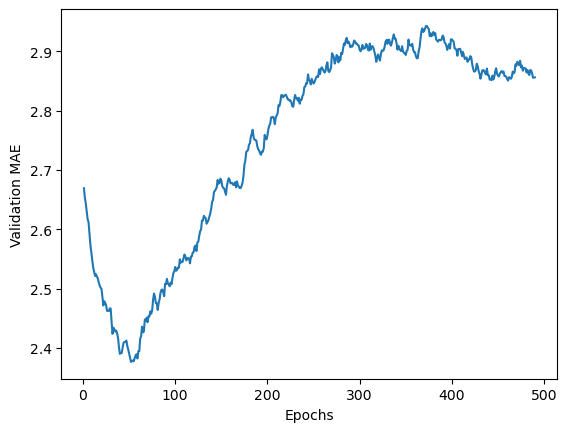

In [40]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Model starts to overfit after 80 epochs -- training should not exceed `num_epochs=80`.